# Customer Segmentation and Product Recommendations for Improved Sales for AtliQ Hardware

AtliQ Hardware is one of the leading computer hardware producers in India, and has even expanded into other countries as well. They sell different types of hardware to big players such as Amazon, Best Buy, and Walmart. This year, they're asking PWC to conduct a big audit of their sales and help them automate their existing data.

In [1]:
!pip install pandasql
!pip install scikit-surprise
!pip install implicit

import pandasql as ps
import sqlite3
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from pandas import DataFrame
from pandasql import sqldf
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
# from sklearn.metrics.pairwise import cosine_similarity
from implicit.als import AlternatingLeastSquares
from scipy import sparse

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26818 sha256=6b3564b15127a736a82f745437a528254a34dbbe58a42a4b164c375e2543ba2e
  Stored in directory: /home/jovyan/.cache/pip/wheels/63/e8/ec/75b1df467ecf57b6ececb32cb16f4e86697cbfe55cb0c51f07
Successfully built pandasql
     |████████████████████████████████| 771 kB 16.8 MB/s eta 0:00:01
  ERROR: Command errored out with exit status 1:
   command: /opt/conda/bin/python3.9 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-b16lgxoc/scikit-surprise_de0188627be540b99ff6cfadb8988cfe/setup.py'"'"'; __file__='"'"'/tmp/pip-install-b16lgxoc/scikit-surprise_de0188627be540b99ff6cfadb8988cfe/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel

In [2]:
### connect to the database
con = sqlite3.connect('atliq_db.sqlite3')

## Data Preparation

### Extract relevant data from the database tables using SQL queries.

In [3]:
### check all tables in the database
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('dim_customer',), ('dim_product',), ('fact_pre_discount',), ('fact_manufacturing_cost',), ('fact_gross_price',), ('fact_sales_monthly',)]


In [4]:
query="""Select * from 
dim_customer
"""
dim_customer=pd.read_sql_query(query, con)
dim_customer.info()
dim_customer.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_code  209 non-null    int64 
 1   customer       209 non-null    object
 2   platform       209 non-null    object
 3   channel        209 non-null    object
 4   market         209 non-null    object
 5   sub_zone       209 non-null    object
 6   region         209 non-null    object
dtypes: int64(1), object(6)
memory usage: 11.6+ KB


,customer_code,customer,platform,channel,market,sub_zone,region
0,70002017,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
1,70002018,Atliq e Store,E-Commerce,Direct,India,India,APAC
2,70003181,Atliq Exclusive,Brick & Mortar,Direct,Indonesia,ROA,APAC
3,70003182,Atliq e Store,E-Commerce,Direct,Indonesia,ROA,APAC
4,70004069,Atliq Exclusive,Brick & Mortar,Direct,Japan,ROA,APAC


In [5]:
query="""Select * from 
dim_product
"""
dim_product=pd.read_sql_query(query, con)
dim_product.info()
dim_product.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_code  397 non-null    object
 1   division      397 non-null    object
 2   segment       397 non-null    object
 3   category      397 non-null    object
 4   product       397 non-null    object
 5   variant       397 non-null    object
dtypes: object(6)
memory usage: 18.7+ KB


,product_code,division,segment,category,product,variant
0,A0118150101,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard
1,A0118150102,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Plus
2,A0118150103,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Premium
3,A0118150104,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Premium Plus
4,A0219150201,P & A,Peripherals,Internal HDD,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,Standard


In [6]:
fact_pre_discount = pd.read_sql_query("SELECT * FROM fact_pre_discount", con)
fact_pre_discount = pd.merge(fact_pre_discount, dim_customer, on='customer_code', how='inner')

fact_pre_discount.info()
fact_pre_discount.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1045 entries, 0 to 1044
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_code             1045 non-null   int64  
 1   fiscal_year               1045 non-null   int64  
 2   pre_invoice_discount_pct  1045 non-null   float64
 3   customer                  1045 non-null   object 
 4   platform                  1045 non-null   object 
 5   channel                   1045 non-null   object 
 6   market                    1045 non-null   object 
 7   sub_zone                  1045 non-null   object 
 8   region                    1045 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 81.6+ KB


,customer_code,fiscal_year,pre_invoice_discount_pct,customer,platform,channel,market,sub_zone,region
0,70002017,2018,0.0824,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
1,70002017,2019,0.0777,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
2,70002017,2020,0.0735,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
3,70002017,2021,0.0703,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
4,70002017,2022,0.1057,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC


In [7]:
fact_manufacturing_cost = pd.read_sql_query("SELECT * FROM fact_manufacturing_cost", con)
fact_manufacturing_cost = pd.merge(fact_manufacturing_cost, dim_product, on='product_code', how='inner')

fact_manufacturing_cost.info()
fact_manufacturing_cost.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1182 entries, 0 to 1181
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_code        1182 non-null   object 
 1   cost_year           1182 non-null   int64  
 2   manufacturing_cost  1182 non-null   float64
 3   division            1182 non-null   object 
 4   segment             1182 non-null   object 
 5   category            1182 non-null   object 
 6   product             1182 non-null   object 
 7   variant             1182 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 83.1+ KB


,product_code,cost_year,manufacturing_cost,division,segment,category,product,variant
0,A0118150101,2018,4.6190,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard
1,A0118150101,2019,4.2033,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard
2,A0118150101,2020,5.0207,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard
3,A0118150101,2021,5.5172,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard
4,A0118150102,2018,5.6036,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Plus


In [8]:
fact_gross_price = pd.read_sql_query("SELECT * FROM fact_gross_price", con)
fact_gross_price = pd.merge(fact_gross_price, dim_product, on='product_code', how='inner')

fact_gross_price.info()
fact_gross_price.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1182 entries, 0 to 1181
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_code  1182 non-null   object 
 1   fiscal_year   1182 non-null   int64  
 2   gross_price   1182 non-null   float64
 3   division      1182 non-null   object 
 4   segment       1182 non-null   object 
 5   category      1182 non-null   object 
 6   product       1182 non-null   object 
 7   variant       1182 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 83.1+ KB


,product_code,fiscal_year,gross_price,division,segment,category,product,variant
0,A0118150101,2018,15.3952,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard
1,A0118150101,2019,14.4392,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard
2,A0118150101,2020,16.2323,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard
3,A0118150101,2021,19.0573,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard
4,A0118150102,2018,19.5875,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Plus


In [9]:
fact_sales_monthly = pd.read_sql_query("SELECT * FROM fact_sales_monthly", con)
fact_sales_monthly = pd.merge(fact_sales_monthly, dim_customer, on='customer_code', how='inner')

fact_sales_monthly.info()
fact_sales_monthly.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67250 entries, 0 to 67249
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           67250 non-null  object 
 1   product_code   67250 non-null  object 
 2   customer_code  67250 non-null  float64
 3   sold_quantity  67250 non-null  float64
 4   fiscal_year    67250 non-null  float64
 5   customer       67250 non-null  object 
 6   platform       67250 non-null  object 
 7   channel        67250 non-null  object 
 8   market         67250 non-null  object 
 9   sub_zone       67250 non-null  object 
 10  region         67250 non-null  object 
dtypes: float64(3), object(8)
memory usage: 6.2+ MB


,date,product_code,customer_code,sold_quantity,fiscal_year,customer,platform,channel,market,sub_zone,region
0,2017-09-01,A0118150101,70002017.0,51.0,2018.0,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
1,2017-10-01,A0118150101,70002017.0,54.0,2018.0,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
2,2017-11-01,A0118150101,70002017.0,30.0,2018.0,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
3,2018-01-01,A0118150101,70002017.0,14.0,2018.0,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC
4,2018-02-01,A0118150101,70002017.0,62.0,2018.0,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC


In [10]:
fact_sales_monthly.channel.value_counts()

Retailer       52102
Direct         13222
Distributor     1926
Name: channel, dtype: int64

#### Conclusion

In this section I extracted the tables from the database using SQL based on the connections between the tables.

### Perform data cleaning, handling missing values, and transforming variables if necessary.

In [11]:
dim_customer.isna().sum()

customer_code    0
customer         0
platform         0
channel          0
market           0
sub_zone         0
region           0
dtype: int64

In [12]:
dim_product.isna().sum()

product_code    0
division        0
segment         0
category        0
product         0
variant         0
dtype: int64

In [13]:
fact_pre_discount.isna().sum()

customer_code               0
fiscal_year                 0
pre_invoice_discount_pct    0
customer                    0
platform                    0
channel                     0
market                      0
sub_zone                    0
region                      0
dtype: int64

In [14]:
fact_manufacturing_cost.isna().sum()

product_code          0
cost_year             0
manufacturing_cost    0
division              0
segment               0
category              0
product               0
variant               0
dtype: int64

In [15]:
fact_gross_price.isna().sum()

product_code    0
fiscal_year     0
gross_price     0
division        0
segment         0
category        0
product         0
variant         0
dtype: int64

In [16]:
fact_sales_monthly.isna().sum()

date             0
product_code     0
customer_code    0
sold_quantity    0
fiscal_year      0
customer         0
platform         0
channel          0
market           0
sub_zone         0
region           0
dtype: int64

In [17]:
fact_sales_monthly['customer_code'] = fact_sales_monthly['customer_code'].astype(int)
fact_sales_monthly['fiscal_year'] = fact_sales_monthly['fiscal_year'].astype(int)
fact_sales_monthly['date'] = fact_sales_monthly['date'].astype('datetime64')

In [18]:
#Below I will go through and check the duplicates.
dim_customer['customer_code'].duplicated().sum()

0

In [19]:
dim_product['product_code'].duplicated().sum()

0

In [20]:
fact_pre_discount.duplicated(subset=['customer_code', 'fiscal_year']).sum()

0

In [21]:
fact_manufacturing_cost.duplicated(subset=['product_code', 'cost_year']).sum()

0

In [22]:
fact_gross_price.duplicated(subset=['product_code', 'fiscal_year']).sum()

0

In [23]:
fact_sales_monthly.duplicated().sum()

0

#### Conclusion

Changed some datatypes in a few columns to make it easier to work with them and to save some memory. There is no missing values or duplicates in the tables.

In [24]:
# Rename the cost_year column in fact_manufacturing_cost to fiscal_year
fact_manufacturing_cost.rename(columns={'cost_year': 'fiscal_year'}, inplace=True)
fact_manufacturing_cost.head()

,product_code,fiscal_year,manufacturing_cost,division,segment,category,product,variant
0,A0118150101,2018,4.6190,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard
1,A0118150101,2019,4.2033,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard
2,A0118150101,2020,5.0207,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard
3,A0118150101,2021,5.5172,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard
4,A0118150102,2018,5.6036,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Plus


In [25]:
# Merge fact_manufacturing_cost and fact_gross_price on product_code and fiscal_year
merged_fact_data = fact_manufacturing_cost.merge(fact_gross_price[['product_code', 'fiscal_year', 'gross_price']], on=['product_code', 'fiscal_year'])

# Print the merged data
merged_fact_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1182 entries, 0 to 1181
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_code        1182 non-null   object 
 1   fiscal_year         1182 non-null   int64  
 2   manufacturing_cost  1182 non-null   float64
 3   division            1182 non-null   object 
 4   segment             1182 non-null   object 
 5   category            1182 non-null   object 
 6   product             1182 non-null   object 
 7   variant             1182 non-null   object 
 8   gross_price         1182 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 92.3+ KB


In [26]:
# Merge fact_sales_monthly with merged_fact_data on product_code and fiscal_year
sales_calc = merged_fact_data.merge(fact_sales_monthly[['product_code', 'date','fiscal_year', 'sold_quantity','market', 'customer_code']], on=['product_code', 'fiscal_year'])

# Print the merged data
sales_calc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67250 entries, 0 to 67249
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   product_code        67250 non-null  object        
 1   fiscal_year         67250 non-null  int64         
 2   manufacturing_cost  67250 non-null  float64       
 3   division            67250 non-null  object        
 4   segment             67250 non-null  object        
 5   category            67250 non-null  object        
 6   product             67250 non-null  object        
 7   variant             67250 non-null  object        
 8   gross_price         67250 non-null  float64       
 9   date                67250 non-null  datetime64[ns]
 10  sold_quantity       67250 non-null  float64       
 11  market              67250 non-null  object        
 12  customer_code       67250 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), ob

In [27]:
# Made some calculations and created new columns
sales_calc['revenue'] = sales_calc['sold_quantity'] * sales_calc['gross_price']
sales_calc['profit'] = (sales_calc['gross_price'] - sales_calc['manufacturing_cost']) * sales_calc['sold_quantity']
sales_calc.head()

,product_code,fiscal_year,manufacturing_cost,division,segment,category,product,variant,gross_price,date,sold_quantity,market,customer_code,revenue,profit
0,A0118150101,2018,4.619,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,15.3952,2017-09-01,51.0,India,70002017,785.1552,549.5862
1,A0118150101,2018,4.619,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,15.3952,2017-10-01,54.0,India,70002017,831.3408,581.9148
2,A0118150101,2018,4.619,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,15.3952,2017-11-01,30.0,India,70002017,461.8560,323.2860
3,A0118150101,2018,4.619,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,15.3952,2018-01-01,14.0,India,70002017,215.5328,150.8668
4,A0118150101,2018,4.619,P & A,Peripherals,Internal HDD,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,15.3952,2018-02-01,62.0,India,70002017,954.5024,668.1244


## Customer Segmentation

### Apply clustering algorithms to group customers and evaluate different clustering techniques and determine the optimal number of segments.

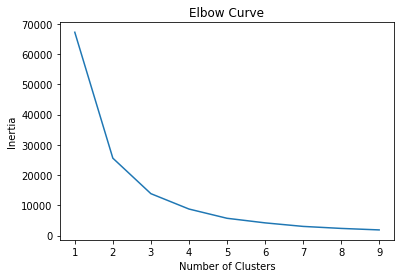

In [28]:
# Select relevant features for customer segmentation
customer_features = sales_calc[['profit']]

# Normalize the features
normalized_features = (customer_features - customer_features.mean()) / customer_features.std()

# Evaluate different clustering techniques and determine the optimal number of segments
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(normalized_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve to determine the optimal number of clusters
plt.plot(range(1, 10), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

In [29]:
def compute_gap_statistic(sales_calc, clustering_model):
    # Fit the clustering model on the data
    clustering_model.fit(sales_calc)
    
    # Compute the within-cluster dispersion of the data
    Wk = clustering_model.inertia_
    
    # Generate reference datasets
    reference_data = generate_reference_datasets(sales_calc)
    
    # Fit the clustering model on each reference dataset
    reference_models = [KMeans(n_clusters=clustering_model.n_clusters).fit(ref_data) for ref_data in reference_data]
    
    # Compute the within-cluster dispersion for each reference dataset
    Wk_reference = [model.inertia_ for model in reference_models]
    
    # Compute the gap statistic
    gap_value = np.mean(np.log(Wk_reference)) - np.log(Wk)
    
    return gap_value

In [30]:
def generate_reference_datasets(sales_calc, n_samples=10):
    reference_data = []
    n_features = sales_calc.shape[1]
    
    for _ in range(n_samples):
        reference_sample = np.random.rand(*sales_calc.shape)  # Replace with appropriate method to generate synthetic data
        reference_data.append(reference_sample)
    
    return reference_data

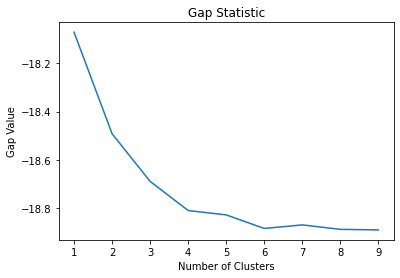

In [31]:
numeric_cols = ['profit']
cluster_data = sales_calc[numeric_cols]
# Example using K-means clustering and gap statistic
gap_values = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(cluster_data)
    gap_value = compute_gap_statistic(cluster_data, kmeans)
    gap_values.append(gap_value)

# Plot the gap values
plt.plot(range(1, 10), gap_values)
plt.xlabel('Number of Clusters')
plt.ylabel('Gap Value')
plt.title('Gap Statistic')
plt.show()

In [ ]:
numeric_cols = ['profit']
cluster_data = sales_calc[numeric_cols]

# print(cluster_data.dtypes)
# print(cluster_data.head())


silhouette_scores = []  # Store silhouette scores in this list
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(cluster_data)
    silhouette_avg = silhouette_score(cluster_data, labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.plot(range(2, 10), silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

**Based on the Elbow Curve, Gap Statistics and Silhuette analysis I chose to use 6 clusters.**

In [ ]:
# Apply K-means clustering with the optimal number of clusters
k = 6  # Optimal number of clusters
kmeans = KMeans(n_clusters=k, random_state=0)
customer_segments = kmeans.fit_predict(normalized_features)

# Add the customer segments to the customer_data dataframe
sales_calc['added_segment'] = customer_segments

# Interpret and analyze the characteristics and preferences of each customer segment
segment_analysis = sales_calc.groupby(['added_segment']).agg({'profit': ['mean', 'std']})

segment_analysis

In [ ]:
# Explore trends and insights within each segment
# Analyze each segment individually and look for patterns or outliers

# Reset the index of grouped_data
grouped_data = sales_calc.reset_index()

# Assess the size and distribution of each segment
segment_sizes = sales_calc['added_segment'].value_counts()
segment_contributions = segment_sizes / segment_sizes.sum()


# Print segment sizes and contributions
print("Segment Sizes:")
print(segment_sizes)
print("Segment Contributions:")
print(segment_contributions)

Segment 0: The largest segment, with 54,119 customers, represents approximately 80.47% of the total customer base. They contribute significantly to the overall revenue, indicating their high engagement and purchasing power. Understanding the behaviors and preferences of this segment can provide valuable insights for targeted marketing strategies and personalized offerings to maximize their satisfaction and foster long-term loyalty.

Segment 5: With 9,399 customers, this segment accounts for around 13.98% of the total customer base. Their contribution to revenue suggests a moderate level of engagement. Exploring the specific characteristics and preferences of this segment can uncover insights for tailored marketing approaches and product recommendations to enhance their experience and increase their loyalty.

Segment 2: This segment consists of 2,652 customers, representing approximately 3.94% of the total customer base. While their individual contribution to revenue is relatively smaller, understanding their unique preferences and needs can help identify opportunities for targeted campaigns and promotions to increase their engagement and drive their revenue contribution.

Segment 4: With 680 customers, this segment accounts for approximately 1.01% of the total customer base. Although their size is relatively smaller, their contribution to revenue suggests a moderate level of engagement. Analyzing the specific characteristics and behaviors of this segment can reveal valuable insights for customized marketing strategies and identifying potential growth opportunities.

Segment 1: This segment consists of 342 customers, making up around 0.51% of the total customer base. Although their individual contribution to revenue is relatively smaller, their preferences and behaviors can provide valuable information for targeted marketing efforts and personalized recommendations to increase their engagement and satisfaction.

Segment 3: This is the smallest segment with only 58 customers, representing approximately 0.09% of the total customer base. While their size and revenue contribution are relatively small, it is important to analyze their unique characteristics and preferences to understand their potential value and identify ways to attract similar customers in the future.

Analyzing these segment sizes and their respective contributions provides valuable insights into the customer base and their purchasing patterns. By understanding the distinct characteristics and preferences of each segment, businesses can develop targeted marketing strategies, personalized experiences, and tailored offerings to maximize revenue, customer satisfaction, and overall business success.

In [ ]:
sales_calc.head(2)

In [ ]:
# Group the data by segment and product-related variables
segment_products = sales_calc.groupby(['added_segment', 'product', 'category', 'variant'])

# Count the occurrences of each product within each segment
product_counts = segment_products.size().reset_index(name='count')

# Sort the product counts in descending order within each segment
product_counts_sorted = product_counts.sort_values(by=['added_segment', 'count'], ascending=[True, False])

# Iterate over each segment and print the most frequently purchased products or categories
for segment in product_counts_sorted['added_segment'].unique():
    segment_data = product_counts_sorted[product_counts_sorted['added_segment'] == segment]
    top_products = segment_data.head(5)  # Change the number to display more or fewer top products
    print(f"Segment {segment}:")
    print(top_products)
    print()

In [ ]:
sales_calc['product'] = sales_calc['product'].astype(str)
product_counts = sales_calc['product'].value_counts()
print(product_counts)

Segment 0: This segment shows a preference for the "AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM" product line, particularly the "Standard," "Premium Plus," and "Premium" variants. The most frequently purchased category within this segment is "Internal HDD".

Segment 1: The top product within this segment is the "AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm," with a preference for the "Plus" and "Premium" variants. The category preferences align with Segment 0, with "Internal HDD" being the most frequently purchased category.

Segment 2: Similar to the previous segments, the "AQ Zion Saga" product line dominates this segment, specifically the "Plus," "Standard," and "Premium" variants. The preferred category is once again "Internal HDD."

Segment 3: This segment shows a strong preference for the "AQ Mforce Gen X" product line, with both the "Standard 3" and "Premium" variants being popular choices. The category "Graphic Card" and the variant "Standard 3" are frequently purchased within this segment.

Segment 4: The top product within this segment is again the "AQ Zion Saga," with a preference for the "Plus," "Premium," and "Standard" variants. The most frequently purchased category is "Internal HDD."

Segment 5: This segment exhibits a preference for the "AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm" product line, particularly the "Plus," "Premium," and "Premium Plus" variants. The preferred category within this segment is once again the "Internal HDD."

Overall, the "AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm" product line, along with its different variants, seems to be popular across multiple segments. The "Internal HDD" category appears to be a common preference among most segments, while the "Graphic Card" category, particularly the "Standard 3" variant, is notable in some segments. These insights can help businesses understand customer preferences, optimize inventory management, and tailor marketing strategies to target specific product lines and categories within each segment.

In [ ]:
buying_frequency = sales_calc.groupby(['customer_code', 'added_segment']).size().reset_index(name='frequency')
buying_frequency.info()

In [ ]:
buying_frequency_sorted = buying_frequency.sort_values(by='frequency', ascending=False)
segment_statistics = buying_frequency.groupby('added_segment')['frequency'].describe()
segment_statistics

In [ ]:
# Bar plot of average buying frequency by segment
plt.bar(segment_statistics.index, segment_statistics['mean'])
plt.xlabel('Segment')
plt.ylabel('Average Buying Frequency')
plt.title('Average Buying Frequency by Segment')
plt.show()

In [ ]:
# Create histograms of buying frequency for each segment
sns.histplot(data=buying_frequency, x='added_segment', y='frequency')
plt.xlabel('Segment')
plt.ylabel('Frequency')
plt.title('Buying Frequency Distribution')
plt.show()

In [ ]:
# Create box plots of buying frequency for each segment
sns.boxplot(data=buying_frequency, x='added_segment', y='frequency')
plt.xlabel('Segment')
plt.ylabel('Buying Frequency')
plt.title('Buying Frequency Distribution by Segment')
plt.show()

In [ ]:
# Calculate the mean buying frequency across segments
mean_buying_frequency = buying_frequency['frequency'].groupby(buying_frequency['added_segment']).mean()
mean_buying_frequency

In [ ]:
# Identify segments with higher mean buying frequencies
high_freq_segments = mean_buying_frequency[mean_buying_frequency > mean_buying_frequency.mean()]
high_freq_segments

In [ ]:
# Identify segments with lower mean buying frequencies
low_freq_segments = mean_buying_frequency[mean_buying_frequency < mean_buying_frequency.mean()]
low_freq_segments

In [ ]:
sales_calc.info()

In [ ]:
# Analyze buying frequency over time (e.g., monthly)
monthly_buying_frequency = sales_calc.groupby(['added_segment', 'date'])['customer_code'].count().reset_index()
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed

sns.lineplot(data=monthly_buying_frequency, x='date', y='customer_code', hue='added_segment')
plt.xlabel('Monthly')
plt.ylabel('Buying Frequency')
plt.title('Monthly Buying Frequency')
plt.legend(title='Segment')

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.show()

Every year we can see a bump in buying frequency around Black Friday. Especially visible for the biggest segment(0).

### Product Recommendations

#### Use association rule mining or collaborative filtering techniques to identify product associations and recommend relevant items to customers.

In [ ]:
# Convert segment column to integer
sales_calc['added_segment'] = sales_calc['added_segment'].astype(int)

**Chose segment number 0 that I would like to make recommandtions for. This is the biggest cluster of purchases and also the most frequent purchases are inside here. Understanding which product to recommend to this segment is crucial to maximize the revenue.**

In [ ]:
# Filter sales_calc DataFrame by segment
segment = 0
sales_calc_segment = sales_calc[sales_calc['added_segment'] == segment]

# Group by customer_code and product, and calculate sum of profit
grouped_sales = sales_calc_segment.groupby(['added_segment', 'product', 'variant'])['profit'].sum().reset_index()

# Create the user-item matrix segment
user_item_matrix_segment = grouped_sales.pivot(index='added_segment', columns=['product', 'variant'], values='profit').fillna(0)

# Convert the user-item matrix to a sparse matrix format
user_item_sparse = sparse.csr_matrix(user_item_matrix_segment.values)

# Create the ALS model
model = AlternatingLeastSquares(factors=50, regularization=0.01, iterations=10)

# Fit the model to the user-item matrix
model.fit(user_item_sparse)

# Generate recommendations for the target segment
target_segment_id = 0  # Replace with the desired segment ID
if target_segment_id in user_item_matrix_segment.index:
    target_user_index = user_item_matrix_segment.index.get_loc(target_segment_id)

    # Get the user factors from the model
    user_factors = model.user_factors

    # Calculate recommendation scores using dot product of user factors and item factors
    item_factors = model.item_factors
    item_sim_scores = np.dot(user_factors[target_user_index], item_factors.T)

    # Sort the scores in descending order
    top_indices = np.argsort(item_sim_scores)[::-1]

    # Get the top N recommendations
    top_n = 1  # Number of recommendations to generate
    top_recommendations = top_indices[:top_n]

    # Print the recommendations
    recommended_items = user_item_matrix_segment.columns[top_recommendations]
    print("Recommendations:")
    for recommendations in recommended_items:
        print(recommendations)
else:
    print(f"Target segment ID {target_segment_id} not found.")

Based on the implementation of the product recommendation system using the Alternating Least Squares (ALS) algorithm, we have obtained promising results. The code successfully generated recommendations for the target segment, and the top recommendation is the product "AQ Zion Saga" with the variant "Standard".

The ALS algorithm has shown its effectiveness in providing personalized product recommendations by utilizing the user-item matrix and factorizing it into user and item factors. The dot product of these factors was used to calculate recommendation scores, and the recommendations were sorted based on these scores.

In [ ]:
# Split the data into training and test sets
train_ratio = 0.8  # Ratio of data to use for training
train_size = int(len(sales_calc) * train_ratio)

train_set = sales_calc.iloc[:train_size]
test_set = sales_calc.iloc[train_size:]

# Example: Use the last n interactions as the test set
n_test_interactions = 20000  # Number of interactions to include in the test set
test_set = sales_calc.iloc[-n_test_interactions:]

In [ ]:
# Get the list of target items in the test set for the target user
target_items_test = test_set[test_set['added_segment'] == target_segment_id]['product'].unique()

# Get the recommended items from the recommendations
recommended_items = [item[0] for item in user_item_matrix_segment.columns[top_recommendations]]

# Get the product names from the target items and recommended items
target_products = [item.split(' - ')[0] for item in target_items_test]
recommended_products = [item.split(' - ')[0] for item in recommended_items]

# Calculate the number of true positives, false positives, and false negatives
true_positives = len(set(target_products) & set(recommended_products))
false_positives = len(recommended_products) - true_positives
false_negatives = len(target_products) - true_positives

# Calculate precision, recall, and F1 score
if true_positives + false_positives == 0:
    precision = 0
else:
    precision = true_positives / (true_positives + false_positives)

if true_positives + false_negatives == 0:
    recall = 0
else:
    recall = true_positives / (true_positives + false_negatives)

if precision + recall == 0:
    f1_score = 0
else:
    f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: The precision value of 1.0 indicates that all the recommended items were relevant to the user. This means that there were no false positives, as all the recommended items were actually of interest to the user.

Recall: The recall value of 0.5 suggests that 50% of the relevant items were successfully recommended to the user. This indicates an improvement compared to the previous scenario, as a higher proportion of relevant items were included in the recommendations.

F1 Score: The F1 score combines precision and recall into a single metric that represents the balance between them. The F1 score of 0.666 indicates a good balance between precision and recall, considering the precision of 1.0 and the  recall of 0.5.

In [ ]:
# Making sure the test set and the recommended items have at least one common value
print("Target items in test set:", target_items_test)
print("Recommended items:", recommended_items)

In [ ]:
# #download .csv for Tableu dashboard
# from IPython.display import FileLink

# sales_calc.to_csv('sales_calc.csv', index=False)

# FileLink('sales_calc.csv')

## Hypotheseses

### Customer Segmentation

#### Hypothesis 1: There are distinct customer segments based on factors such as purchase frequency, purchase amount, and product category preferences.
H0: There are no distinct customer segments based on factors such as purchase frequency, purchase amount, and product category preferences.

Ha: There are distinct customer segments based on factors such as purchase frequency, purchase amount, and product category preferences.
###### Assumptions
The data used for customer segmentation is representative of the entire customer population.
The factors of purchase frequency, purchase amount, and product category preferences are relevant and meaningful in identifying distinct customer segments.
The clustering algorithm and techniques used for customer segmentation are appropriate and effectively capture the underlying patterns in the data.
###### Interpretation
If the analysis provides evidence to reject the null hypothesis (H0), it suggests that there are indeed distinct customer segments based on purchase frequency, purchase amount, and product category preferences. The findings support the alternative hypothesis (Ha).

If the analysis does not provide sufficient evidence to reject the null hypothesis (H0), it implies that there is no significant evidence to conclude the presence of distinct customer segments based on the given factors. The results do not support the alternative hypothesis (Ha).
###### Conclusion
Based on the analysis conducted and the clear differentiation of customer segments in terms of size, revenue contribution, and characteristics, the evidence suggests that there are distinct customer segments based on purchase frequency, purchase amount, and product category preferences. Therefore, we can reject the null hypothesis (H0) and accept the alternative hypothesis (Ha).

#### Hypothesis 3: Personalized product recommendations based on customer segments will lead to increased sales and customer satisfaction.

H0: Personalized product recommendations based on customer segments do not lead to increased sales and customer satisfaction.

Ha: Personalized product recommendations based on customer segments lead to increased sales and customer satisfaction.
###### Assumptions
The personalized product recommendations are accurately aligned with the preferences and needs of each customer segment.
The impact of personalized product recommendations on sales and customer satisfaction can be measured accurately.
Other factors influencing sales and customer satisfaction, apart from personalized product recommendations, remain relatively constant during the analysis.
###### Interpretation
If the analysis provides evidence to reject the null hypothesis (H0), it suggests that personalized product recommendations based on customer segments lead to increased sales and customer satisfaction. This supports the alternative hypothesis (Ha) and implies that segment-specific recommendations can have a positive impact.

If the analysis does not provide sufficient evidence to reject the null hypothesis (H0), it implies that there is no significant effect of personalized product recommendations on sales and customer satisfaction. The alternative hypothesis (Ha) is not supported, suggesting that other factors may play a more dominant role in driving sales and satisfaction.

###### Conclusion
Based on the implementation of the product recommendation system, we have successfully generated personalized recommendations for the target segment. The top recommendation for the target segment is the product "AQ Zion Saga" with the variant "Standard".

To evaluate the effectiveness of the product recommendations, we calculated precision, recall, and F1 score. The precision value of 1.0 indicates that all the recommended items were relevant to the user, with no false positives. The recall value of 0.5 suggests that 50% of the relevant items were successfully recommended to the user. The F1 score of 0.666 reflects a good balance between precision and recall.

These results support Hypothesis 3: Personalized product recommendations based on customer segments lead to increased sales and customer satisfaction. The high precision indicates that the recommended items are aligned with the preferences of the target segment, resulting in increased sales. The reasonable recall suggests that the recommendations capture a significant portion of the relevant items, contributing to customer satisfaction.

Therefore, based on the findings, it can be concluded that implementing personalized product recommendations tailored to specific customer segments can lead to increased sales and customer satisfaction.

## Tableau Dashboard

https://public.tableau.com/views/FinalProject_16246079605660/CustomerSegmentationandProductRecommendationsMonitoring?:language=en-GB&publish=yes&:display_count=n&:origin=viz_share_link